In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py 
import visualisation as vis
import metric_dreem
import torch
import torch.nn as nn
from torch.optim import Adam
import utils 
import tqdm

In [4]:
import importlib
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\sacha\\Desktop\\CentraleSupélec\\cours 3a\\SD10\\DataScience\\sleepapnea\\Code\\utils.py'>

# Description of data

We have 44 nights (subjects) of 200 windows (samples) of 90 seconds sampled at 100 Hz (so 9000 points per window)

Half of the 44 nights are in the training set (so **4400 samples**) and the other half in the test set

Each window has **8 features so 72000 points** + 2 indexes :

- 0: sample index
- 1: subject index
- 2 to 9001: Abdominal belt
- 9002 to 18001: Airflow
- 18002 to 27001: PPG (Photoplethysmogram)
- 27002 to 36001: Thoracic belt
- 36002 to 45001: Snoring indicator
- 45002 to 54001: SPO2
- 54002 to 63001: C4-A1
- 63002 to 72001:O2-A1

In [5]:
SIGNALS_NAME = ["AbdoBelt","AirFlow","PPG","ThorBelt","Snoring","SPO2","C4A1","O2A1"]
nb_features = len(SIGNALS_NAME)

In [6]:
data_x_train = h5py.File('../data/X_train.h5')
data_x_test = h5py.File('../data/X_test.h5')
data_x_train['data'].shape, data_x_test['data'].shape

((4400, 72002), (4400, 72002))

**Description of masks:**

X mask is a stairway function that tells us which subjects corresponds to each sample 

Y mask is our target: it tells us for every sample if the subject is in apnea for each **second**

In [7]:
mask_x_train = np.array(pd.read_csv('../data/X_train.csv'))
mask_x_test = np.array(pd.read_csv('../data/X_test.csv'))
mask_y_train = np.array(pd.read_csv('../data/y_train.csv'))
mask_y_subject = mask_y_train[:,1:].reshape(22,-1)
mask_x_train.shape, mask_x_test.shape, mask_y_train.shape, mask_y_subject.shape

((4400, 2), (4400, 2), (4400, 91), (22, 18000))

# Pre-processing for CNN

**subsampling the input**

In [8]:
# create sub-sampled dataset
n_samples = 4400
n_subjects = 22
rate = 20

sampled_data = utils.subsampling_data(data_x_train,rate)
sampled_data.shape

(4400, 8, 450)

**normalization**

In [9]:
print('means: ',sampled_data.mean(axis=(0,2)))
print('vars: ' ,sampled_data.var(axis=(0,2)))

means:  [ 5.88803497e+00 -2.84034858e+01 -8.57776287e+02 -9.01286089e+00
  6.93812603e+02  9.19423312e+04  4.48062714e-04 -1.33528544e-04]
vars:  [2.25591784e+05 3.24042724e+03 1.73710956e+06 1.82991720e+05
 2.14398908e+05 2.75255645e+08 3.15588880e+02 3.15475730e+02]


In [10]:
# normalization of data (centering + reducing)
utils.normalization(sampled_data)
print('means: ',sampled_data.mean(axis=(0,2)))
print('vars: ' ,sampled_data.var(axis=(0,2)))

means:  [ 6.53573716e-18  2.33133378e-16 -2.72425853e-16 -1.55027506e-18
 -2.23945845e-15 -1.89537634e-15  2.24433267e-18  1.10802220e-17]
vars:  [1. 1. 1. 1. 1. 1. 1. 1.]


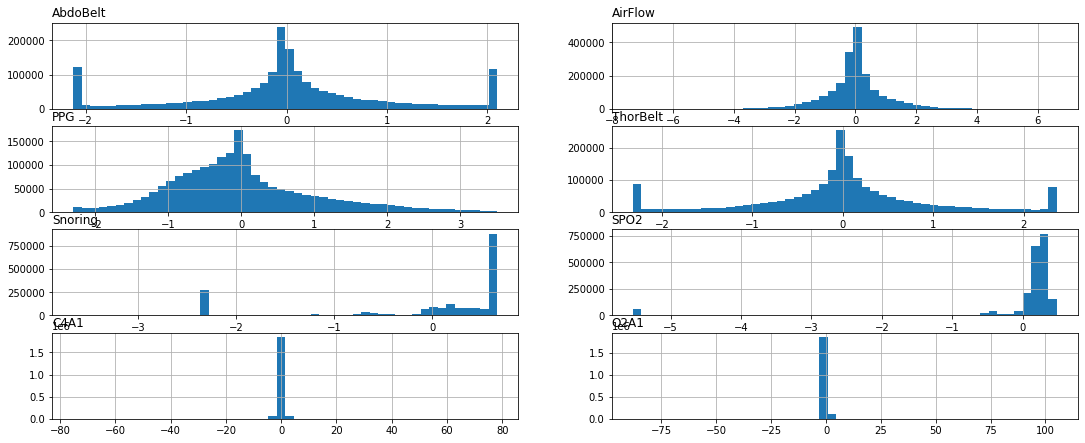

In [11]:
for k in range(8):
    plt.subplot(4,2,k+1)
    pd.Series(sampled_data[:,k].reshape(-1)).hist(bins=50)
    plt.title(SIGNALS_NAME[k],loc='left')
plt.subplots_adjust(right=2.5, top=1.5)


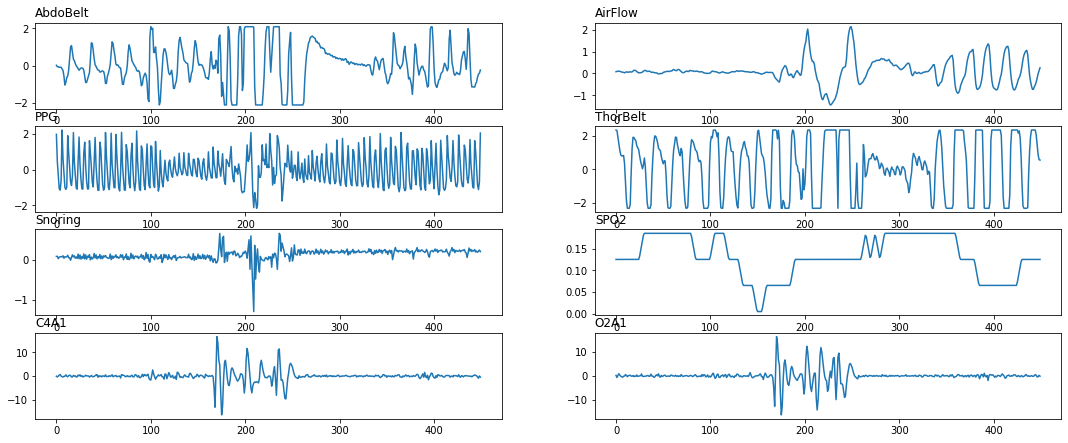

In [12]:
# random plot / plot 0
for k in range(8):
    plt.subplot(4,2,k+1)
    plt.plot(sampled_data[np.random.randint(4400)*0][k])
    plt.title(SIGNALS_NAME[k],loc='left')
plt.subplots_adjust(right=2.5, top=1.5)

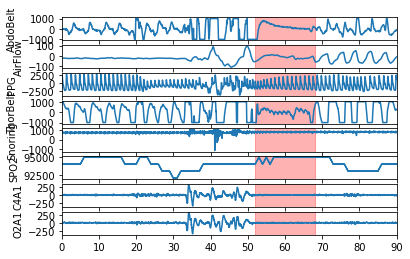

In [13]:
vis.visualise_index(0,data_x_train, mask_y_train)

**creating targets**

In [14]:
targets = mask_y_train[:,1:]
mask_y_train.shape

(4400, 91)

# Loading the data

In [15]:
# splittin train/valid : we use 5 subjects for validation
training_size = 200*17

**increasing the size of our dataset**

In [16]:
# we only increase the training dataset
augmented_data, augmented_targets = utils.data_augmentation(sampled_data[:training_size], targets[:training_size],new_seconds=5, n_subjects=17)
print('we had {} samples of 90 sec, now we have {}'.format(sampled_data.shape[0], augmented_data.shape[0]))

we had 4400 samples of 90 sec, now we have 60911


**choosing  a better distribution of targets by sampling**

In [17]:
print("percentage of positive targets: {:.2f} % ".format(100*augmented_targets.mean()))

percentage of positive targets: 7.10 % 


in 79.55% of data, everything is null


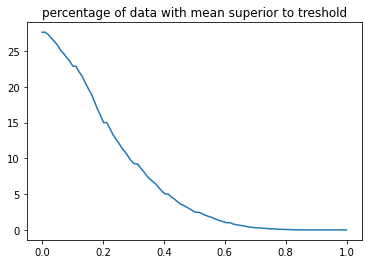

In [18]:
plt.plot( np.linspace(0,1,100), [(augmented_targets.mean(axis=1)>k/100).mean()*100 for k in range(100)])
plt.title('percentage of data with mean superior to treshold')
print('in {:.2f}% of data, everything is null'.format(100 - targets.max(axis=1).mean()*100))

as we see, 80% of the data is full of zeros
 - *idea*: augment data then remove half of the all zero

In [19]:
training_data, training_targets = utils.eliminating_zeros(augmented_data, augmented_targets, kept_zeros_rate=0.4)
training_targets.shape[0], augmented_targets.shape[0]

(34735, 60911)

in 79.55% of old data, everything is null
in 51.54% of new data, everything is null


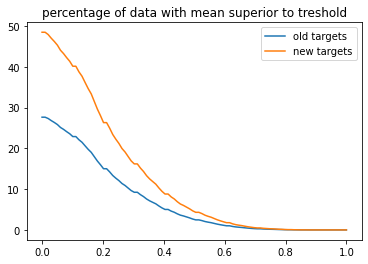

In [20]:
plt.plot( np.linspace(0,1,100), [(augmented_targets.mean(axis=1)>k/100).mean()*100 for k in range(100)], label = 'old targets')
plt.plot( np.linspace(0,1,100), [(training_targets.mean(axis=1)>k/100).mean()*100 for k in range(100)], label = 'new targets')
plt.legend()
plt.title('percentage of data with mean superior to treshold')
print('in {:.2f}% of old data, everything is null'.format(100 - targets.max(axis=1).mean()*100))
print('in {:.2f}% of new data, everything is null'.format(100 - training_targets.max(axis=1).mean()*100))

In [21]:
print("percentage of positive new targets: {:.2f} % ".format(100*training_targets.mean()))

percentage of positive new targets: 12.46 % 


**loading data for training**

In [22]:
#Dataloader
train_loader, valid_loader = utils.dataloader(training_data, training_targets, sampled_data[training_size:], targets[training_size:], batch_size=32)

The train set contains 34735 samples, in 1086 batches
The validation set contains 1000 samples, in 32 batches


# Model definition

In [23]:
# hyper parameters
CNN_shape = [8,16,32,64,128]
kernel_shape = [5,5,5,3]
drop_out = 0.35
#'8,450->16,225->32,112->48,56->64,28
FNN_shape = [CNN_shape[-1]*(450//2**(len(CNN_shape)-1)), 256 , 90]
CNN_shape, FNN_shape

([8, 16, 32, 64, 128], [3584, 256, 90])

In [24]:
# Model definition 

def conv_relu_maxpool(cin, cout, csize, cstride, cpad, msize, mstride, mpad, drop=0):
    return [nn.Dropout(drop),
            nn.Conv1d(cin, cout, csize, cstride, cpad),
            nn.BatchNorm1d(cout),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(msize, mstride, mpad)]

def linear_relu(dim_in, dim_out, drop=0):
    return [nn.Dropout(drop),
            nn.Linear(dim_in, dim_out),
            nn.ReLU()]

def linear_tanh(dim_in, dim_out, drop=0):
    return [nn.Dropout(drop),
            nn.Linear(dim_in, dim_out),
            nn.tanh()]

def linear_sigm(dim_in, dim_out, drop=0):
    return [nn.Dropout(drop),
            nn.Linear(dim_in, dim_out),
            nn.Sigmoid()]

conv_model  = nn.Sequential(
    *conv_relu_maxpool(cin=CNN_shape[0], cout=CNN_shape[1],                   # 8,450 -> 16,225
                       csize=kernel_shape[0], cstride=1, cpad=2,
                       msize=2, mstride=2, mpad=0, drop=0),  
    *conv_relu_maxpool(cin=CNN_shape[1], cout=CNN_shape[2],                   # 16,225 -> 32,112
                       csize=kernel_shape[1], cstride=1, cpad=2,
                       msize=2, mstride=2, mpad=0, drop=drop_out),
    *conv_relu_maxpool(cin=CNN_shape[2], cout=CNN_shape[3],                   # 32,112 -> 64,56
                       csize=kernel_shape[2], cstride=1, cpad=2,
                       msize=2, mstride=2, mpad=0, drop=drop_out),
    *conv_relu_maxpool(cin=CNN_shape[3], cout=CNN_shape[4],                   # 64,56 -> 128,18
                       csize=kernel_shape[3], cstride=1, cpad=1,
                       msize=2, mstride=2, mpad=0, drop=drop_out)
                       )

fc_model = nn.Sequential(
    *linear_relu(FNN_shape[0],FNN_shape[1], drop= drop_out	),
    #*linear_relu(FNN_shape[1],FNN_shape[2]),
    *linear_sigm(FNN_shape[-2], FNN_shape[-1]) 
    )


In [25]:
# code here
class CNNModel(torch.nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_model = conv_model
        self.fc_model = fc_model

    def forward(self, inputs):
        conv_features = self.conv_model(inputs.float())
        #Flatten data before fully connected layers
        conv_features = conv_features.view(conv_features.shape[0], -1)
        fc_features = self.fc_model(conv_features)
        return fc_features

In [26]:
model = CNNModel()
print(model)

CNNModel(
  (conv_model): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.35, inplace=False)
    (6): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.35, inplace=False)
    (11): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.35, inpla

# Model training and testing

In [27]:
# code here
optimizer = Adam(model.parameters(), lr=0.001)
f_loss = nn.BCELoss()
f_loss = 'special'
weighted_loss = 80
weighted_threshold = 1 - 1/weighted_loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, 
                                                       threshold_mode='rel', cooldown=2, min_lr=0, eps=1e-08, verbose=False)



In [28]:
import importlib
importlib.reload(utils)
model.__init__()
model =  utils.train_model(train_loader, valid_loader, model,  f_loss, optimizer, scheduler, num_epochs = 40, 
                            special_weight = weighted_loss  )

  0%|          | 0/1086 [00:00<?, ?it/s]Epoch 0/39
----------
  0%|          | 2/1086 [00:00<01:02, 17.27it/s]val Loss: 0.0253 Acc: 26.9310

Epoch 1/39
----------
  0%|          | 2/1086 [00:00<00:54, 19.86it/s]val Loss: 0.0267 Acc: 29.1960

Epoch 2/39
----------
  0%|          | 2/1086 [00:00<00:59, 18.33it/s]val Loss: 0.0238 Acc: 30.4380

Epoch 3/39
----------
  0%|          | 2/1086 [00:00<01:01, 17.70it/s]val Loss: 0.0241 Acc: 29.5280

Epoch 4/39
----------
  0%|          | 2/1086 [00:00<00:55, 19.36it/s]val Loss: 0.0246 Acc: 31.5010

Epoch 5/39
----------
  0%|          | 2/1086 [00:00<01:00, 17.96it/s]val Loss: 0.0249 Acc: 33.7570

Epoch 6/39
----------
  0%|          | 2/1086 [00:00<01:11, 15.18it/s]val Loss: 0.0253 Acc: 33.0520

Epoch 7/39
----------
  0%|          | 2/1086 [00:00<01:06, 16.26it/s]val Loss: 0.0237 Acc: 31.4060

Epoch 8/39
----------
  0%|          | 2/1086 [00:00<01:35, 11.31it/s]val Loss: 0.0274 Acc: 39.5680

Epoch 9/39
----------
  0%|          | 2/1086 [00:0

In [29]:
predictions = model.forward(torch.tensor(valid_loader.dataset.inputs)).detach().numpy()
predictions.mean(), valid_loader.dataset.targets.mean()

(0.57778543, 0.060477777777777776)

In [30]:
1 - 1/20

0.95

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\sacha\Desktop\CentraleSupélec\cours 3a\SD10\DataScience\sleepapnea\Code\metric_dreem.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(result)
100%|██████████| 1000/1000 [01:00<00:00, 16.46it/s]


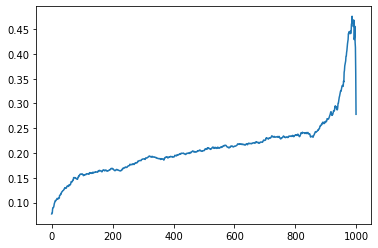

In [31]:
threshold_grid_search = np.zeros(1000)
for k in tqdm.tqdm(range(1000)):
    threshold_grid_search[k] = metric_dreem.dreem_sleep_apnea_custom_metric(predictions>k/1000, valid_loader.dataset.targets)
plt.plot(threshold_grid_search)

In [64]:
weighted_threshold, np.argmax(threshold_grid_search)/1000

threshold_grid_search[round(weighted_threshold*1000)], np.max(threshold_grid_search)

(0.46870451237263466, 0.47619047619047616)

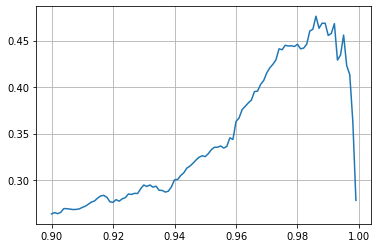

In [65]:
plt.plot([k/1000 + 0.9 for k in range(100)], threshold_grid_search[900:])
plt.grid()

In [66]:
results = metric_dreem.dreem_sleep_apnea_custom_metric(utils.low_band_filter(predictions>weighted_threshold).reshape(5,-1), 
                                            valid_loader.dataset.targets.reshape(5,-1))
best_results = np.load("best_results.npy")
print('results: {:.4f} , best results: {:.4f}'.format(results, best_results))

results: 0.4886 , best results: 0.4886
c:\Users\sacha\Desktop\CentraleSupélec\cours 3a\SD10\DataScience\sleepapnea\Code\metric_dreem.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(result)


In [67]:
predictions.shape
sensitivity = np.sum(np.multiply(predictions, valid_loader.dataset.targets))/np.sum(valid_loader.dataset.targets)
specificity = np.sum(np.multiply(1.0 - predictions, 1.0 - valid_loader.dataset.targets))/np.sum(1.0 - valid_loader.dataset.targets)
print("sensitivity: ", sensitivity, " , specificity: ", specificity)

sensitivity:  0.9045144800458979  , specificity:  0.44324636202130785


In [70]:
# only if results are good
if results>=best_results:
    np.save('best_results.npy', np.array(results) )
    torch.save(model.state_dict(), 'best_model_parameters')
    dummy_input = next(iter(train_loader))[0]
    torch.onnx.export(model, dummy_input, 'CNN_DataScience.onnx')
    print('new model saved!')
'done'

new model saved!


'done'

In [71]:
load_model = CNNModel()
load_model.load_state_dict(torch.load('best_model_parameters'))

<All keys matched successfully>

In [95]:
load_predictions = load_model.forward(torch.tensor(valid_loader.dataset.inputs)).detach().numpy()>=weighted_threshold*0.999
metric_dreem.dreem_sleep_apnea_custom_metric(utils.low_band_filter(load_predictions), valid_loader.dataset.targets )

c:\Users\sacha\Desktop\CentraleSupélec\cours 3a\SD10\DataScience\sleepapnea\Code\metric_dreem.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(result)


0.49926144756277696

In [96]:
metric_dreem.dreem_sleep_apnea_custom_metric(utils.low_band_filter(load_predictions.reshape(5,-1),positive_only=0), valid_loader.dataset.targets.reshape(5,-1) )

0.5070422535211268

In [94]:
load_predictions.mean()

0.05722222222222222

In [74]:
### try on test data
test_sampled_data = utils.subsampling_data(data_x_test, rate, special=1)
test_sampled_data = utils.normalization(test_sampled_data)


In [41]:
test_predictions = load_model.forward(torch.tensor(test_sampled_data)).detach().numpy()
test_predictions.mean()

0.5378426

In [42]:
(test_predictions>=weighted_threshold*0.996).mean()

0.06063383838383839

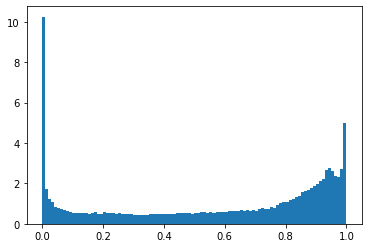

In [78]:
plt.hist(predictions.reshape(-1),  bins= 100, density=1)
plt.show()

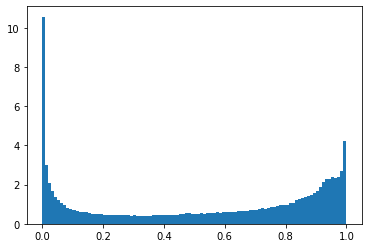

In [82]:
plt.hist(test_predictions.reshape(-1), bins = 100, density=1)
plt.show()

In [90]:
filtered_test_predictions = utils.low_band_filter(test_predictions.reshape(22,-1)>=weighted_threshold*0.999, positive_only=0).reshape(4400,90)

In [91]:
filtered_test_predictions.mean()

0.052593434343434345

In [92]:
Y_test = pd.DataFrame(filtered_test_predictions, columns = pd.read_csv('../data/y_train.csv').columns[1:], index=np.linspace(4400,8799,4400), dtype=int)
Y_test.describe()

y_0          y_1          y_2          y_3          y_4  \
count  4400.000000  4400.000000  4400.000000  4400.000000  4400.000000   
mean      0.044318     0.048636     0.052955     0.053636     0.052045   
std       0.205824     0.215131     0.223968     0.225324     0.222144   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               y_5          y_6          y_7          y_8          y_9  ...  \
count  4400.000000  4400.000000  4400.000000  4400.000000  4400.000000  ...   
mean      0.056136     0.055455     0.053409     0.053182     0.053636  ...   
std       0.230211     0.228891     0.224873     0.224421     0.225324  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
max       1.000000     1.000000     1.000000     1.000000     1.000000  ...   

              y_80         y_81         y_82         y_83         y_84  \
count  4400.000000  4400.000000  4400.000000  4400.000000  4400.000000   
mean      0.044545     0.044545     0.044318     0.042955     0.043409   
std       0.206327     0.206327     0.205824     0.202778     0.203799   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              y_85         y_86         y_87         y_88         y_89  
count  4400.000000  4400.000000  4400.000000  4400.000000  4400.000000  
mean      0.043864     0.041591     0.039545     0.035682     0.032500  
std       0.204815     0.199675     0.194911     0.185517     0.177344  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 90 columns]

In [93]:
Y_test.to_csv('../data/y_test_cnn_weighted_loss.csv')

In [97]:
Benchmark_test = np.array(pd.read_csv('../benchmark/y_benchmark.csv'))[:,1:]

In [49]:
weighted_threshold*0.996

0.98355

In [102]:
mixed_model_data = Benchmark_test*1
k=0
for s in range(4400):
    for t in range(90):
        if Benchmark_test[s,t]!=(test_predictions[s,t]>=weighted_threshold*0.999):
            k+=1
            if Benchmark_test[s,t]:
                mixed_model_data[s,t] = test_predictions[s,t]>0.9
                # if benchmark is 1 we keep it if our model is close to saying it's also 1
            else:
                mixed_model_data[s,t] = test_predictions[s,t] >0.99 
                # if benchmark is 0 we change it if our model is really sure it's one
print('percentage of difference', k/44/90, '%')

percentage of difference 7.505050505050505 %


In [100]:
mixed_model_data.mean(), Benchmark_test.mean(), filtered_test_predictions.mean(), utils.low_band_filter(mixed_model_data, positive_only=0).mean()

(0.08018686868686868,
 0.0842550505050505,
 0.052593434343434345,
 0.08013131313131314)

In [52]:
Y_mixed = pd.DataFrame(utils.low_band_filter(mixed_model_data, positive_only=0), columns = pd.read_csv('../data/y_train.csv').columns[1:], index=np.linspace(4400,8799,4400), dtype=int)
Y_mixed.to_csv('../data/y_test_w_mixed_model.csv')